# GradCAM
Grad-CAM, or Gradient-weighted Class Activation Mapping, is a class-disciminative explainability technique used in deep learning to visualize and understand the decisions made by convolutional neural networks (CNNs). Essentially, it helps to explain "why" a neural network made a particular prediction.   

Here's a breakdown of what it does:

#### Visual Explanations:
Grad-CAM produces a "heatmap" that highlights the regions of an input image that were most important for the network's prediction.   
This allows us to see which parts of the image the network "looked at" when making its decision.   

#### How it Works:
Grad CAM uses the gradient information flowing into the last convolutional layer of the CNN to assign importance values to each neuron for a particular decision of interest. 
It analyzes the gradients of the target output (e.g., a specific class score) with respect to the feature maps in the final convolutional layer of the CNN.   
These gradients indicate the importance of each feature map, and they are combined to create the heatmap.



To obtain class-discriminative localization map Grad-CAM $ {L}^{c}_{Grad-CAM} \in  \mathbb{R}^{uxv} $ of width $u$ and height $v$ of any class $c$, we calculate the gradient for the score of class $c$, $y^c$ (before the softmax), with respect to feature map activations $A^k$, i.e., $\frac{\partial y^c}{\partial A_{ij}^{k}}$.
These gradients flowing back are global-averaged pooled over width and height dimensions (indexed by i and j respectively) to obtain neuron importance weights of ${\alpha}^{c}_{k}$.


\begin{equation*}
{\alpha}^{c}_{k} = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A_{ij}^{k}}
\end{equation*}

Then a weighted combination of forward activation maps is performed, which is followed by a ReLU to obtain

\begin{equation*}
{L}^{c}_{Grad-CAM} = ReLU (\sum_{k} {\alpha}^{c}_{k}{A^k} )
\end{equation*}

This results in a coarse heatmap of the same size as the convolutional feature maps (14 x 14) in case of last convolutionallayers of VGG.

ReLU is used to only retain the pixels that have a positive impact on the prediction, whose intensity should be increased in order to increase the class score of interest. 

#### Intuition
- Deeper representations in a CNN capture high level visual constructs.
- CNN layers retain the spatial information that is lost in the fully connected layers, hence the last convolutional layer can be expected to have the best compromise between high level semantics and detailed spatial information.

We will implement the GradCAM and apply it to the VGG-16 predictions. 



In [68]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn.functional as F
base_dir = "../data/"

First, let us import the pretrained VGG16 model from the Pytorch library and set it to the eval mode.
On a closer look at the layers of our VGG16 model, we can see that the 28th layer is the final convolutional layer in the network that we will use to be the target layer for our Grad-CAM. 

In [69]:
# Load the pre-trained VGG16 model
vgg16_model = models.vgg16(weights="VGG16_Weights.DEFAULT")

#Last rectified conv layer
vgg16_model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [70]:
target_layer = vgg16_model.features[28]

We will load a sample image and preprocess it with the following function to make it compatible with the VGG model. 

In [71]:
def preprocess_image(image_path):
    """
    Preprocesses an image for VGG classifier.

    Args:
        image_path (str): Path to the image file.

    Returns:
        torch.Tensor: Preprocessed image as a PyTorch tensor.
    """
    # Define the transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)

    # Apply the transformations
    image_tensor = preprocess(image)

    return image_tensor

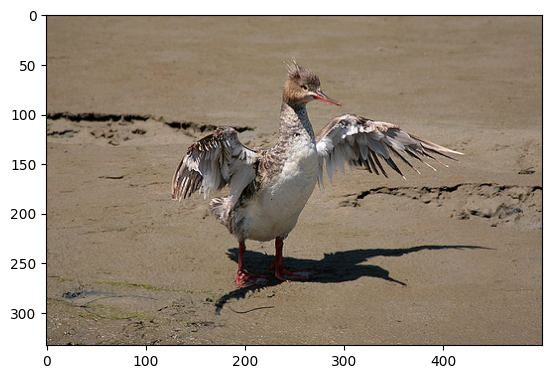

In [72]:
image_path = base_dir + "red-breasted_merganser.jpeg"#"bulbul.jpeg"
input_tensor = preprocess_image(image_path)
input_batch = input_tensor.unsqueeze(0)

In [73]:
imagenet_classes_filepath = base_dir + "imagenet_classes.txt"
with open(imagenet_classes_filepath) as f:
    imagenet_classes = eval(f.read())

Next we will make the predictions for the input image to get the class scores. The output is a tensor of shape [1, 1000], the maximum value and the corresponding index of which specifies the class score and the predicted label respectively. 

In [74]:
with torch.no_grad():
    output = vgg16_model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities).item()
predicted_label = imagenet_classes[predicted_class]

For the Grad CAM calculation, we would require the following data:
1. The forward activations of final convolutional layer, i.e., target layer.
2. The gradient of the class score with respect to the target layer.

For that, we require intermediate values from the model, during our forward and backward pass. We will do that by attaching "hook" to our model. But what are hooks?

### Hooks
In PyTorch, "hooks" allow you to attach functions to certain modules or layers of a model. They are called during the execution of a PyTorch module, when the attached module is invoked.
#### - Purpose:
Hooks provide a way to inspect or modify the behavior of a PyTorch module without altering its core code.   
They are useful for debugging, monitoring, and manipulating the intermediate values of tensors during computation.   
#### - Types:
Forward hooks: Called during the forward pass of a module.   
Backward hooks: Called during the backward pass (gradient computation) of a module.   
#### - Functionality:
You register a hook function with a specific module or tensor.   
The hook function is then automatically called when the corresponding event occurs.
The hook function can examine the input and output tensors, and even modify them.


We will require a forward hook for the ativations and a backward hook for the gradients. We introduce them in our code as follows:

In [75]:
def forward_hook_fn(module, input, output):
    global activations
    activations = output[0].detach()

def backward_hook_fn(module, input, output):
    global grad
    grad = output[0][0].detach()

hook_f = target_layer.register_forward_hook(forward_hook_fn)
hook_b = target_layer.register_backward_hook(backward_hook_fn)
output = vgg16_model(input_batch)
predicted_class = torch.argmax(output).item()

hook_f.remove()
hook_b.remove()
print(f"Predicted class: {predicted_class}")
loss = output[0][predicted_class]
vgg16_model.zero_grad()
loss.backward()


Predicted class: 98


In [77]:
grad_averaged = grad.mean(dim = (1,2)).reshape(-1,1,1)
cam = grad_averaged*activations
cam = cam.sum(dim = 0).unsqueeze(0)
cam = cam.unsqueeze(0)
cam = F.interpolate(cam, input_tensor.shape[1:], mode='bilinear', align_corners=False)
cam_min = torch.min(cam)
cam_max = torch.max(cam)
cam -= cam_min
cam /= (cam_max - cam_min)

### Projection of the GradCAM on the image

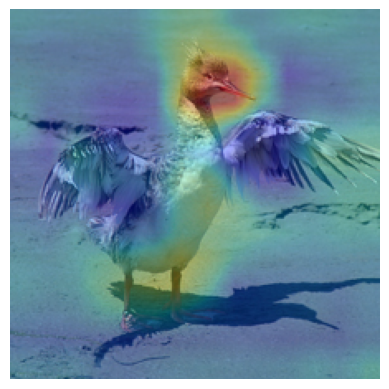

In [78]:
import matplotlib.pyplot as plt
min = input_tensor.min()
max = input_tensor.max()
input_tensor -= min
input_tensor /= (max - min)
plt.imshow(input_tensor.permute(1,2,0))
plt.imshow(cam[0][0], cmap='jet', alpha=0.3)
plt.axis('off')
plt.show()

The following cell introduces a class for GradCAM that uses the code above. 

The following code creates a class for GradCAM using the code above. 

In [79]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.target_layer = target_layer
        self.model = model
        self.activations = None
        self.grad = None
        self.hook_f = None
        self.hook_b = None
        self.cam = None
        self.image = None

    def forward_hook_fn(self, module, input, output):
        self.activations = output[0].detach()

    def backward_hook_fn(self, module, input, output):
        self.grad = output[0][0].detach()

    def _register_hook(self):
        self.hook_f = self.target_layer.register_forward_hook(self.forward_hook_fn)
        self.hook_b = self.target_layer.register_backward_hook(self.backward_hook_fn)

    def remove_hooks(self):
        self.hook_f.remove()
        self.hook_b.remove()

    def execute(self, image_path):

        input_tensor = preprocess_image(image_path)
        input_batch = input_tensor.unsqueeze(0)
        
        self._register_hook()
        output = self.model(input_batch)
        predicted_class = torch.argmax(output).item()
        
        print(f"Predicted class: {predicted_class}")
        loss = output[0][predicted_class]
        self.model.zero_grad()
        loss.backward()

        self.remove_hooks()


        grad_averaged = grad.mean(dim = (1,2)).reshape(-1,1,1)
        cam = grad_averaged*activations
        cam = cam.sum(dim = 0).unsqueeze(0)
        cam = cam.unsqueeze(0)
        cam = F.interpolate(cam, input_tensor.shape[1:], mode='bilinear', align_corners=False)
        cam_min = torch.min(cam)
        cam_max = torch.max(cam)
        cam -= cam_min
        cam /= (cam_max - cam_min)

        self.cam = cam
        self.image = input_batch


        min = input_tensor.min()
        max = input_tensor.max()
        input_tensor -= min
        input_tensor /= (max - min)
        plt.imshow(input_tensor.permute(1,2,0))
        plt.imshow(cam[0][0], cmap='jet', alpha=0.3)
        plt.axis('off')
        plt.show()

        
        return self.cam

                

Predicted class: 98


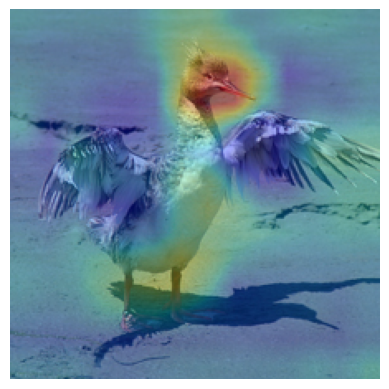

In [80]:
gradcam = GradCAM(vgg16_model,  target_layer)
cam = gradcam.execute(image_path)